In [1]:
# imports
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
# Models
from sklearn.base import BaseEstimator, TransformerMixin

import xgboost as xgb
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, quantile_transform
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE
from sklearn.impute import SimpleImputer, KNNImputer

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append("../")

import utils_ML as uml
import AtlasAnalysisFunctions as AAF

In [2]:
# Load datasets
data_combat = pd.read_csv("../preprocessing/combat_NSAF_50.csv", index_col = "assay_id")
data_quantile = pd.read_csv("../preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")
data_median_norm = pd.read_csv("../preprocessing/median_scaling_50.csv", index_col = "Unnamed: 0")
data_nsaf = pd.read_csv("../preprocessing/NSAF_50.csv", index_col = "assay_id")
data_nsaf = np.log2(data_nsaf)

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data_combat.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data_combat.sort_index(inplace=True)
data_quantile.sort_index(inplace=True)
data_median_norm.sort_index(inplace=True)
data_nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

missing_value_mask = data_nsaf.isna()
data_combat = data_combat.where(~missing_value_mask, other=np.nan)

data_combat = data_combat.reset_index(drop=True).rename(columns={data_combat.columns[x]:x for x in range(len(data_combat.columns))})
data_quantile = data_quantile.reset_index(drop=True).rename(columns={data_quantile.columns[x]:x for x in range(len(data_quantile.columns))})
data_median_norm = data_median_norm.reset_index(drop=True).rename(columns={data_median_norm.columns[x]:x for x in range(len(data_median_norm.columns))})
data_nsaf = data_nsaf.reset_index(drop=True).rename(columns={data_nsaf.columns[x]:x for x in range(len(data_nsaf.columns))})

In [3]:
target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


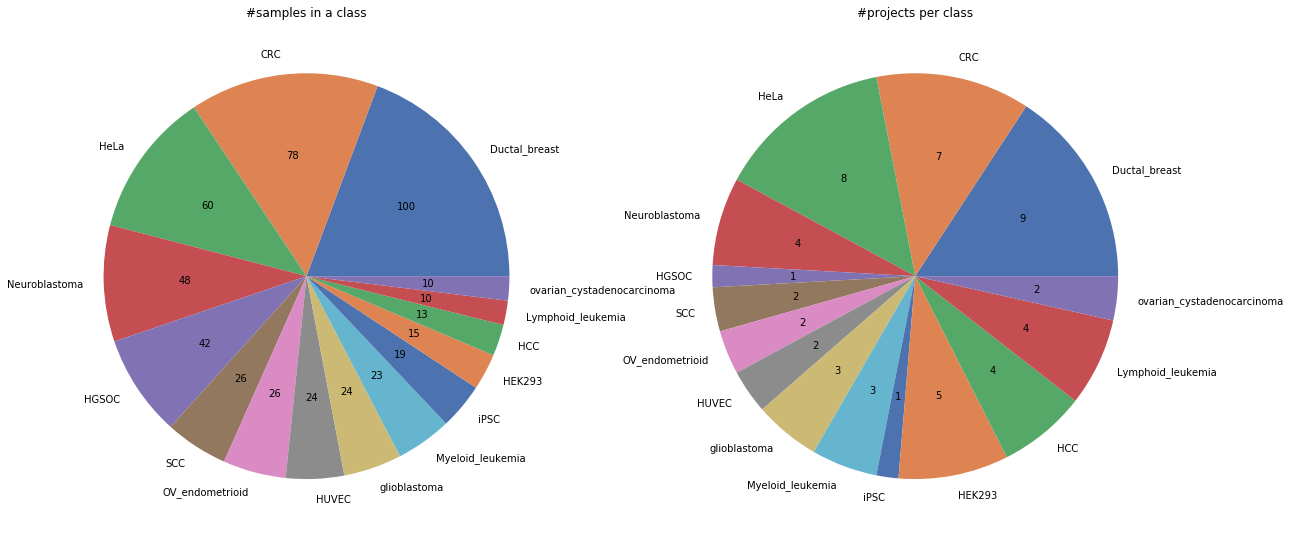

In [4]:
apc = meta.Group.value_counts(sort = True)
label_order = apc.index
ppc = meta.groupby("Group", sort = False).nunique().PXD_accession[label_order]

fig = plt.figure(figsize=(20,10))
fig.set_facecolor("white")

plt.subplot(121)
plt.title("#samples in a class")
_ = plt.pie(apc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct= lambda p: '{:.0f}'.format(p*sum(apc.values)/100))

plt.subplot(122)
plt.title(r"#projects per class")
_ = plt.pie(ppc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct = lambda p: '{:.0f}'.format(p*sum(ppc.values)/100))

# Normalization
- Quantile normalization
- Equalize medians of 90% reoccurring proteins normalization
- ComBat normalization
- NSAF (unnormalized)

# Imputation methods
- left-shifted Gaussian
- KNNimputation
- PCA imputation (~SVDimpute)
- Combination of gaussian and PCA/KNN

# Feature selection methods
- Univariate: Anova and MI
- Model-based: linear SVM, LR, RF
- Clustering proteins (K-medoids based)

# Oversampling
- Weights
- SMOTE
- SMOTE-Tomek
- SMOTE-EEN
- VAE - SMOTE-Tomek

# Machine learning modelling
- LR
- SVM
- RF
- XGBoost
- LGBM
- Naive Bayes
- K-nearest Neighbours

In [4]:
lr_clf = LogisticRegression(max_iter=10000)
svm_clf = SVC()
rf_clf = RandomForestClassifier()
xgb_clf = xgb.XGBClassifier()
lgbm_clf = lgbm()
nb_clf = GaussianNB()
knn_clf = KNeighborsClassifier()

models = [lr_clf, svm_clf, rf_clf, lgbm_clf]

# Parameter grids
lr_grid = {"penalty" : ['l2', 'l1'],
            "dual": [False],
            "max_iter": [10000],
            "class_weight": [weights],
            "C": np.linspace(0.005, 15, 10),
            'solver': ['newton-cg', 'sag', 'lbfgs', "liblinear"]}

svc_grid = {'decision_function_shape': ["ovr"],
            "kernel": ['linear', 'poly', 'rbf'],
            "C": np.linspace(0.0005, 5, 10),
            "class_weight": [weights]}

rf_grid = {'n_estimators': np.linspace(10, 200, 4, dtype = int),
            "criterion": ["entropy", "gini"], 
            "max_depth": [10,20,40, None],
            "class_weight": [weights]}

xgb_grid = {"verbosity": [0],
            'eta': np.linspace(0.005,0.5,5),
            'gamma': np.linspace(0.005,10,5),
            'max_depth': [3,5,7,10]}

gnb_grid = {'var_smoothing': np.logspace(0,-15,15)}


grids = {"lr": lr_grid, "svc": svc_grid, "rf": rf_grid, "gnb": gnb_grid}

In [5]:
imputation_methods = [uml.MNAR_MCAR_Imputer(max_iter=15, MCAR_estimator='knn'), uml.MNAR_MCAR_Imputer(max_iter=15, MCAR_estimator='pca'), uml.LowestValueImputerGaussian(), KNNImputer(n_neighbors=10), uml.MNAR_MCAR_Imputer(missing_percentage=1, MCAR_estimator='pca', max_iter=15)]
imputation_ids = ["KNN+LOD", "PCA+LOD", "Shifted Gaussian", "KNNImpute", "PCA"]
dataset_ids = ["NSAF", "ComBat", "Quantile", "Median Norm"]

In [6]:
selector = uml.FeatureSelector(selectors=["anova", "MI", "LR", "SVC"], num_features=300, threshold=.75)

In [11]:
imputer = uml.MNAR_MCAR_Imputer(max_iter=15, MCAR_estimator='pca').fit(data_quantile, targets)
data_quant_imputed = imputer.transform(data_quantile,targets)

First iteration: 0
iteration: 0
Components: 317
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14


In [16]:
imputer = uml.MNAR_MCAR_Imputer(max_iter=15, MCAR_estimator='pca').fit(data_quantile, targets)
data_quant_imputed2 = imputer.transform(data_quantile,targets)

First iteration: 0
iteration: 0
Components: 317
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14


In [69]:
data_nsaf = pd.read_csv("../preprocessing/NSAF_50.csv", index_col = "assay_id")

In [72]:
random_labels = labels==17
np.random.shuffle(random_labels)

In [ ]:
list(data_nsaf.columns[labels==17])

In [85]:

import requests ## python -m pip install requests
import time

mean_scores = []
for permutation in range(100):
    time.sleep(0.5)
    print(permutation)
    string_api_url = "https://version-11-5.string-db.org/api"
    output_format = "tsv-no-header"
    method = "network"

    ##
    ## Construct URL
    ##

    request_url = "/".join([string_api_url, output_format, method])

    ##
    ## Set parameters
    ##
    random_labels = labels==17
    np.random.shuffle(random_labels)
    my_genes = list(data_nsaf.columns[random_labels])

    params = {

        "identifiers" : "%0d".join(my_genes), # your protein
        "species" : 9606, # species NCBI identifier 
        "caller_identity" : "www.awesome_app.org" # your app name

    }

    ##
    ## Call STRING
    ##

    response = requests.post(request_url, data=params)

    df_output = []
    for line in response.text.strip().split("\n"):

        l = line.strip().split("\t")
        df_output.append(l)
    
    output = pd.DataFrame(df_output, columns="P1 P2 name1 name2 taxon score nscore fscore pscore ascore escore dscore tscore".split())
    output = output.astype({x:'float' for x in'score nscore fscore pscore ascore escore dscore tscore'.split()})
    mean_scores.append(output.score.mean())
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [88]:
np.mean(mean_scores) + 2*np.std(mean_scores)

0.7682137319811478

In [93]:
(mean_scores > observed_score).sum() / 100

0.08

In [89]:
observed_score

0.7563571428571428

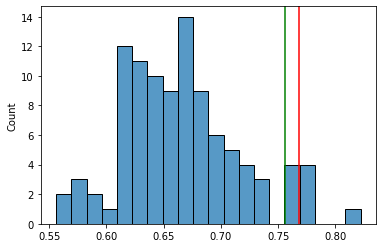

In [98]:
sns.histplot(mean_scores,bins=20)
plt.axvline(observed_score,c='g')
plt.axvline(np.mean(mean_scores) + 2*np.std(mean_scores), c="r")

In [84]:
observed_score = output.score.mean()

In [83]:
data_nsaf.columns[[2235,2516]]

Index(['Q9NR30', 'Q9Y2X3'], dtype='object')

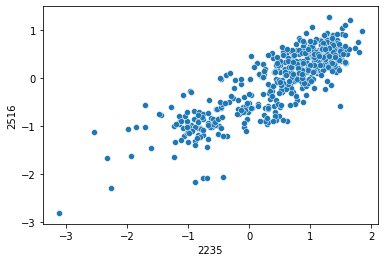

In [77]:
sns.scatterplot(x=data_median_norm_imputed.loc[:,2235], y=data_median_norm_imputed.loc[:,2516])

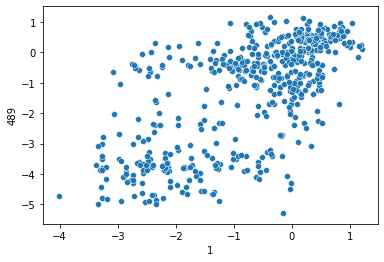

In [80]:
sns.scatterplot(x=data_median_norm_imputed.loc[:,1], y=data_median_norm_imputed.loc[:,489])

In [12]:
corr_matrix=data_quant_imputed.corr()
distance_matrix = 1-abs(corr_matrix)

In [17]:
corr_matrix2=data_quant_imputed2.corr()
distance_matrix2 = 1-abs(corr_matrix)

In [76]:
largest_corr = 0
for x in range(2615):
    corrs = corr_matrix.replace(1,0).loc[x,:].sort_values()
    if corrs.iloc[-1] > largest_corr:
        print("update:", x, corrs.index[-1], corrs.iloc[-1])
        largest_corr = corrs.iloc[-1]

update: 0 1213 0.4449701414876254
update: 1 489 0.6737481439516105
update: 52 219 0.7566553488670643
update: 168 2572 0.8260185394042356
update: 2235 2516 0.8529098395860563


In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
clustering_model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
clustering_model.fit(data_median_norm_imputed.T)

AgglomerativeClustering(n_clusters=10)

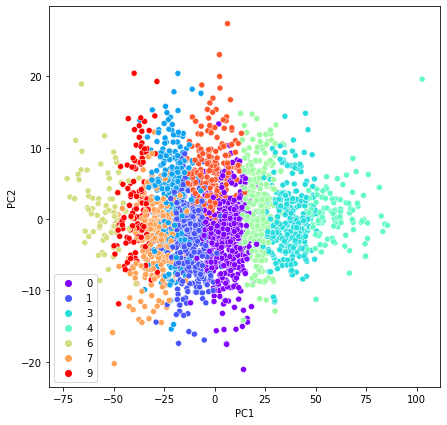

In [30]:


clustering_model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
clustering_model.fit(data_median_norm_imputed.T)
plt.figure(figsize=(7,7))
embedded = PCA(2).fit_transform(data_median_norm_imputed.T)
sns.scatterplot(data=pd.DataFrame(data=embedded, columns=["PC1", "PC2"], index=data_median_norm.columns),
                x="PC1", y="PC2", hue=clustering_model.labels_, palette="rainbow")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


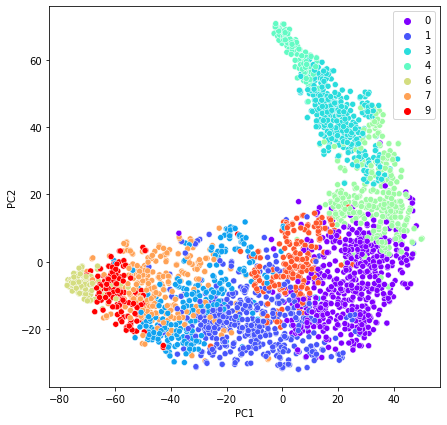

In [24]:
plt.figure(figsize=(7,7))
embedded = TSNE(perplexity=15).fit_transform(data_median_norm_imputed.T)
sns.scatterplot(data=pd.DataFrame(data=embedded, columns=["PC1", "PC2"], index=data_median_norm.columns),
                x="PC1", y="PC2", hue=clustering_model.labels_, palette="rainbow")

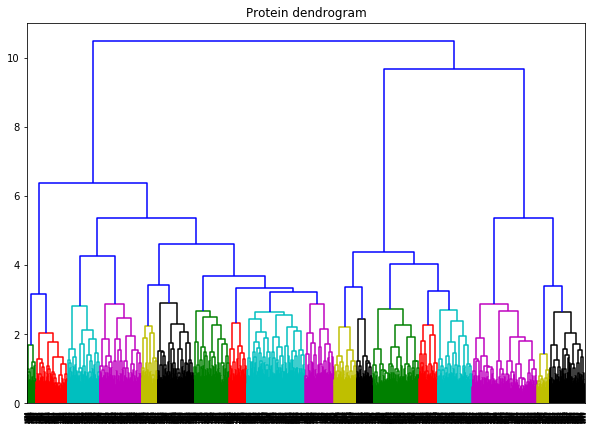

In [15]:
plt.figure(figsize=(10, 7))
plt.title("Protein dendrogram")

# Selecting Annual Income and Spending Scores by index
clusters = shc.linkage(squareform(distance_matrix), 
            method='ward')

shc.dendrogram(Z=clusters, color_threshold=3)
plt.show()

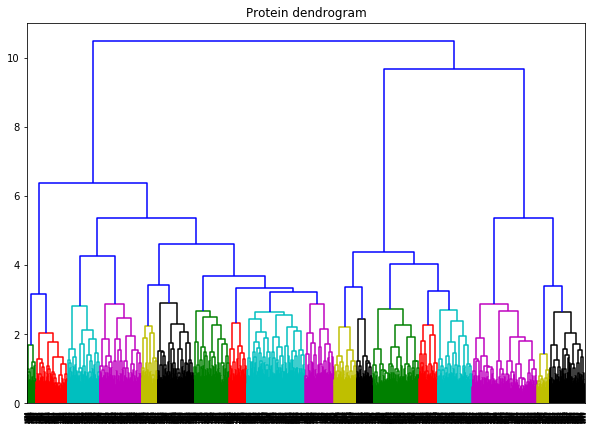

In [22]:
plt.figure(figsize=(10, 7))
plt.title("Protein dendrogram")

# Selecting Annual Income and Spending Scores by index
clusters = shc.linkage(squareform(distance_matrix2), 
            method='ward')

shc.dendrogram(Z=clusters, color_threshold=3)
plt.show()

In [23]:
labels = shc.fcluster(clusters,t=3, criterion="distance")

In [30]:
np.unique(labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int32)

In [61]:
random_labels = labels==14
np.random.shuffle(random_labels)

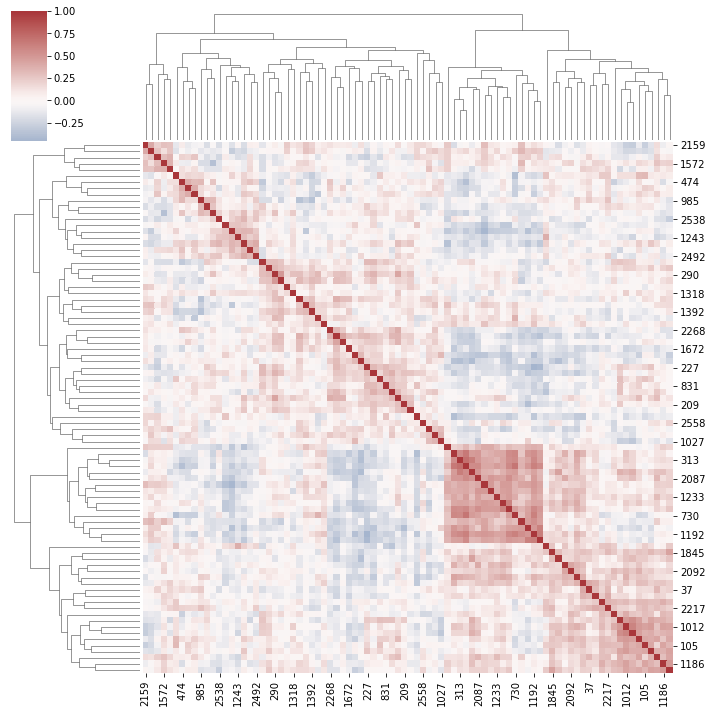

In [62]:
sns.clustermap(data_quant_imputed.loc[:,random_labels].corr(), cmap="vlag", center = 0)

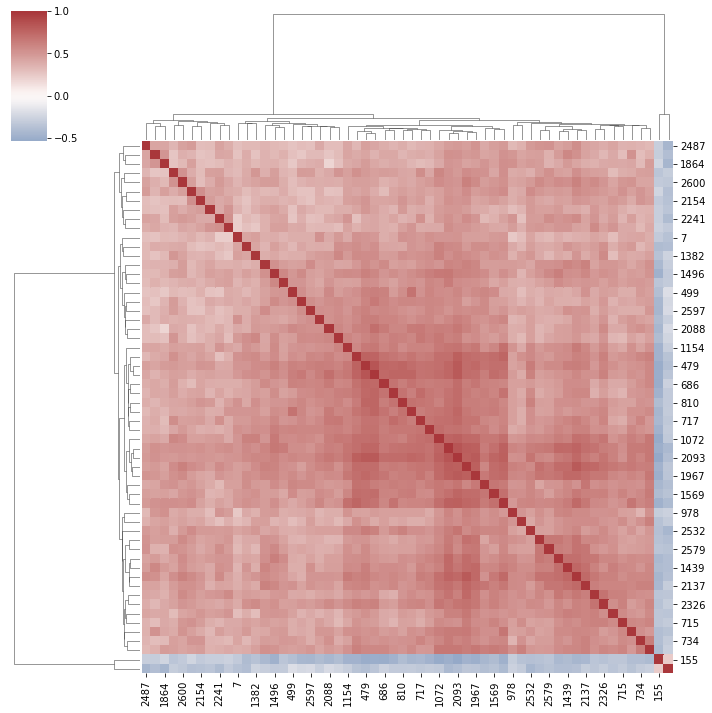

In [68]:
sns.clustermap(data_quant_imputed.loc[:,labels==17].corr(), cmap="vlag", center = 0)

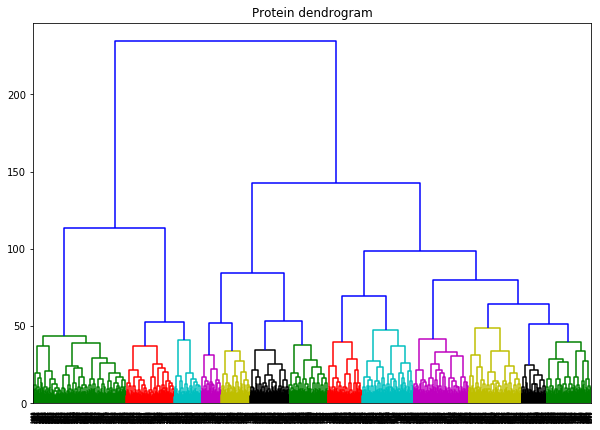

In [17]:
plt.figure(figsize=(10, 7))
plt.title("Protein dendrogram")

# Selecting Annual Income and Spending Scores by index
clusters = shc.linkage(squareform(distance_matrix), 
            method='ward')

shc.dendrogram(Z=clusters, color_threshold=50)
plt.show()

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


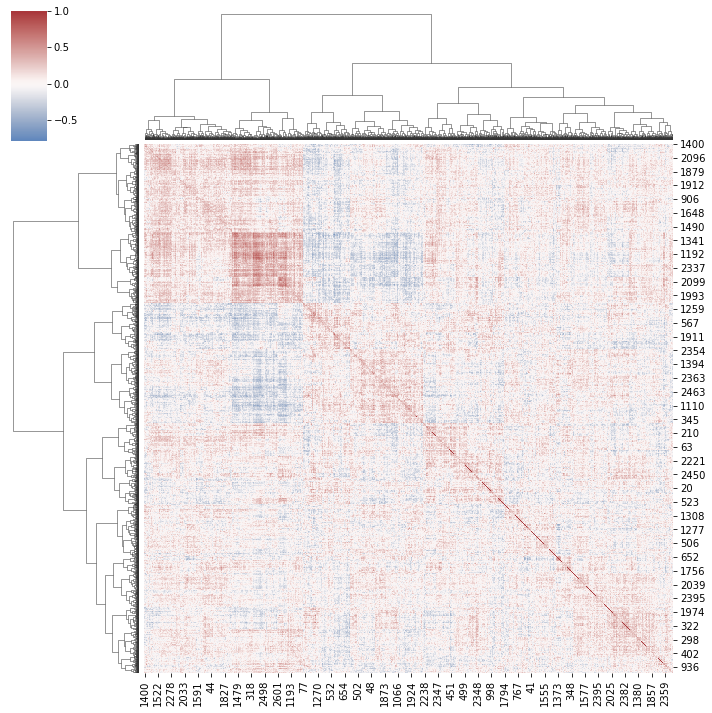

In [58]:
sns.clustermap(data_corr, method="ward", metric='euclidean', cmap="vlag", center = 0)

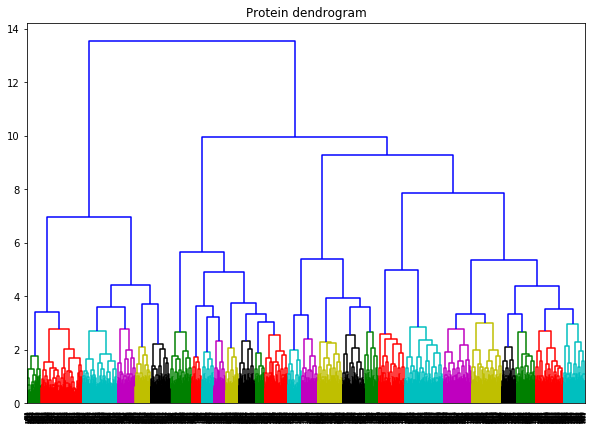

In [62]:
plt.figure(figsize=(10, 7))
plt.title("Protein dendrogram")

# Selecting Annual Income and Spending Scores by index
clusters = shc.linkage(squareform(1-data_corr), 
            method='ward', 
            metric="correlation")

shc.dendrogram(Z=clusters, color_threshold=3)
plt.show()

In [75]:
labels = shc.fcluster(clusters,t=4,criterion="distance")

In [71]:
mm_med = MinMaxScaler().fit_transform(data_median_norm_imputed)

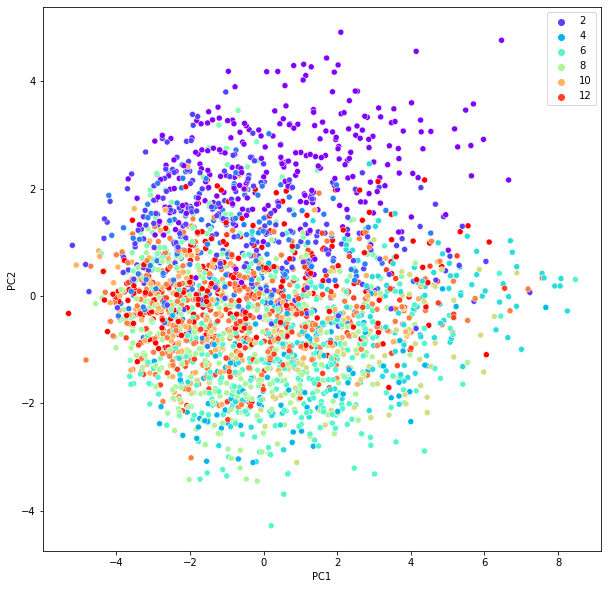

In [76]:
plt.figure(figsize=(10,10))
embedded = PCA(2).fit_transform(mm_med.T)
sns.scatterplot(data=pd.DataFrame(data=embedded, columns=["PC1", "PC2"], index=data_median_norm.columns),
                x="PC1", y="PC2", hue=labels, palette="rainbow")

In [1]:
d = shc.distance.pdist(corr_matrix, metric="correlation")
L = shc.linkage(d, method='ward')

# Determine the clusters using a distance threshold of 0.5 times the maximum distance
max_dist = d.max()
cluster_labels = shc.fcluster(L, 0.5*max_dist, 'distance')

# Plot the dendrogram with color-coded clusters
dendrogram = shc.dendrogram(L, color_threshold=0.5*max_dist)

# Print the cluster labels

NameError: name 'shc' is not defined

In [139]:
len(np.unique(cluster_labels))

214

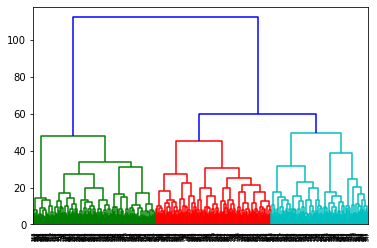

In [128]:
R = shc.dendrogram(Z=clusters, color_threshold=50)

In [133]:
R.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

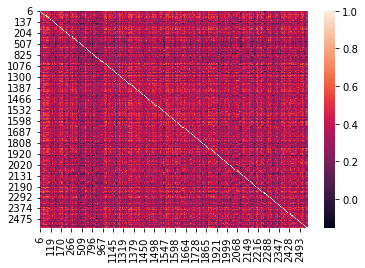

In [114]:
sns.heatmap(data_corr.loc[clustering_model.labels_ == 2, clustering_model.labels_ == 2])

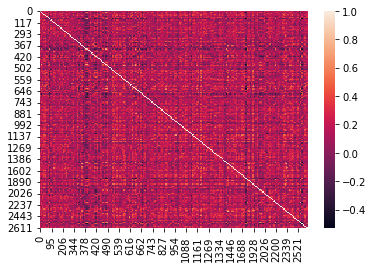

In [113]:
sns.heatmap(data_corr.loc[clustering_model.labels_ == 1, clustering_model.labels_ == 1])

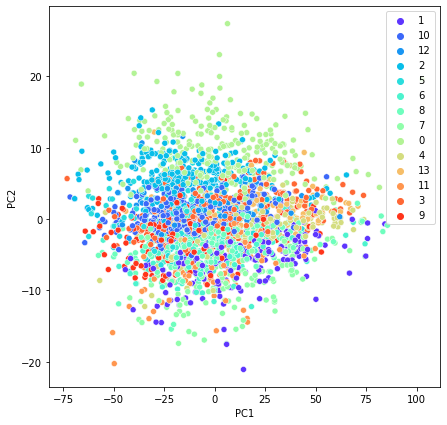

In [105]:
clustering_model = AgglomerativeClustering(n_clusters=14, affinity='euclidean', linkage='ward')
clustering_model.fit(data_corr)
plt.figure(figsize=(7,7))
embedded = PCA(2).fit_transform(data_median_norm_imputed.T)
sns.scatterplot(data=pd.DataFrame(data=embedded, columns=["PC1", "PC2"], index=data_median_norm.columns),
                x="PC1", y="PC2", hue=[str(x) for x in clustering_model.labels_], palette="rainbow")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


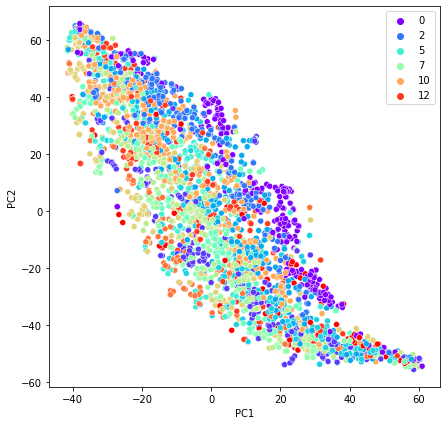

In [106]:
plt.figure(figsize=(7,7))
embedded = TSNE(perplexity=15).fit_transform(data_median_norm_imputed.T)
sns.scatterplot(data=pd.DataFrame(data=embedded, columns=["PC1", "PC2"], index=data_median_norm.columns),
                x="PC1", y="PC2", hue=clustering_model.labels_, palette="rainbow")

In [96]:
shc.distance.pdist(data_corr, metric = 'correlation')

array([0.78797515, 1.37834002, 0.71618963, ..., 0.28506434, 0.689299  ,
       0.49836131])

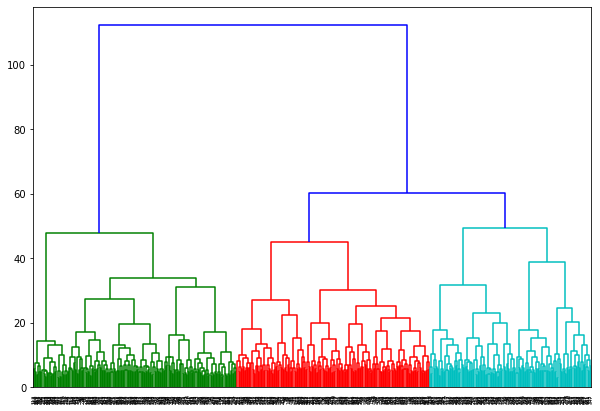

In [101]:
plt.figure(figsize=(10, 7))
clusters = shc.linkage(data_corr.loc[np.random.permutation(data_median_norm.shape[0]),:], 
            method='ward', 
            metric="euclidean")

shc.dendrogram(Z=clusters, color_threshold=50)
plt.show()

# Normalization and imputation

In [8]:
# Step one: Estimate performance of vanilla models on each type of normalization, each imputed with a certain imputation strategy, with feature selection
# Performance measured both with SKF and Projectbased splits
# Measured: Which model performs optimal overall? Which imputation method performs optimal overall? Which dataset performs optimal overall?

skf = StratifiedKFold(n_splits=10, shuffle=True)

fold = 0
for train, test in skf.split(X=data_nsaf, y=targets):
    fold+=1
    # For each normalization method
    # Get train datasets
    X_train_nsaf = data_nsaf.iloc[train, :].reset_index(drop=True)
    X_train_combat = data_combat.iloc[train, :].reset_index(drop=True)
    X_train_quantile = data_quantile.iloc[train,:].reset_index(drop=True)
    X_train_med = data_median_norm.iloc[train, :].reset_index(drop=True)
    X_train = [X_train_nsaf, X_train_combat, X_train_quantile, X_train_med]

    # Get test datasets
    X_test_nsaf = data_nsaf.iloc[test, :].reset_index(drop=True)
    X_test_combat = data_combat.iloc[test, :].reset_index(drop=True)
    X_test_quantile = data_quantile.iloc[test,:].reset_index(drop=True)
    X_test_med = data_median_norm.iloc[test, :].reset_index(drop=True)
    X_test = [X_test_nsaf, X_test_combat, X_test_quantile, X_test_med]

    # Get label stratifications
    Y_train = targets[train]
    Y_test = targets[test]

    # For each imputation method
    for impute_i, imputation_method in enumerate(imputation_ids):
        # For each normalization method
        for i in range(4):
            
            # Impute
            if imputation_method == "KNNImpute":
                scaler = MinMaxScaler()
                scaled_train = scaler.fit_transform(X_train[i])
                scaled_test = scaler.fit_transform(X_test[i])

                imputer = KNNImputer(n_neighbors=10)
                imputer.fit(scaled_train)
                scaled_train = imputer.transform(scaled_train)
                scaled_test = imputer.transform(scaled_test)

            else:
                imputer = imputation_methods[impute_i]
                imputer.fit(X_train[i], Y_train)
                imputed_train = imputer.transform(X_train[i], Y_train)
                imputed_test = imputer.transform(X_test[i])

                # Standardize
                scaler = MinMaxScaler()
                scaled_train = scaler.fit_transform(imputed_train)
                scaled_test = scaler.transform(imputed_test)

            selector.fit(scaled_train, Y_train)
            X_train_selection = selector.transform(scaled_train)
            X_test_selection = selector.transform(scaled_test)

            # For each model
            print("Training models")
            for clf in models:
                #if type(clf).__name__ == 'XGBClassifier':
                    
                #    xgb_train = xgb.DMatrix(X_train_selection, label=Y_train, weight = [weights[x] for x in Y_train])
                #    xgb_test = xgb.DMatrix(X_test_selection)
                    
                #    clf.fit(xgb_train, Y_train)
                #    Y_pred = clf.predict(xgb_test)
                
                #else:
                clf.set_params(class_weight = weights)
                clf.fit(X_train_selection, Y_train)
                Y_pred = clf.predict(X_test_selection)

                micro_f1, macro_f1, weighted_f1, cm = uml.scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
                results_df = pd.DataFrame({"model": [type(clf).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm],
                                        "Imputation": [imputation_method], "Normalization": [dataset_ids[i]]})
                
                uml.save_results(results_df, "norm_imputer_evaluation")

                print("Fold, imputation: ",fold, imputation_method)

First iteration: 0
iteration: 0
Components: 298
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 272
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
Training models
Fold, imputation:  1 KNN+LOD
Fold, imputation:  1 KNN+LOD
Fold, imputation:  1 KNN+LOD
Fold, imputation:  1 KNN+LOD
First iteration: 0
iteration: 0
Components: 326
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 308
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 

In [ ]:
# Step one: Estimate performance of vanilla models on each type of normalization, each imputed with a certain imputation strategy, with feature selection
# Performance measured both with SKF and Projectbased splits
# Measured: Which model performs optimal overall? Which imputation method performs optimal overall? Which dataset performs optimal overall?

pbkf = uml.ProjectBasedSplit(splits=10, metadata=meta, on="Group", LOOCV=True)

fold = 0
for train, test in pbkf.split(dataset=data_nsaf, metadata=meta, n_projects=20):
    fold+=1
    # For each normalization method
    # Get train datasets
    X_train_nsaf = data_nsaf.iloc[train, :].reset_index(drop=True)
    X_train_combat = data_combat.iloc[train, :].reset_index(drop=True)
    X_train_quantile = data_quantile.iloc[train,:].reset_index(drop=True)
    X_train_med = data_median_norm.iloc[train, :].reset_index(drop=True)
    X_train = [X_train_nsaf, X_train_combat, X_train_quantile, X_train_med]

    # Get test datasets
    X_test_nsaf = data_nsaf.iloc[test, :].reset_index(drop=True)
    X_test_combat = data_combat.iloc[test, :].reset_index(drop=True)
    X_test_quantile = data_quantile.iloc[test,:].reset_index(drop=True)
    X_test_med = data_median_norm.iloc[test, :].reset_index(drop=True)
    X_test = [X_test_nsaf, X_test_combat, X_test_quantile, X_test_med]

    # Get label stratifications
    Y_train = targets[train]
    Y_test = targets[test]

    # For each imputation method
    for impute_i, imputation_method in enumerate(imputation_ids):
        # For each normalization method
        for i in range(4):
            
            # Impute
            if imputation_method == "KNNImpute":
                scaler = MinMaxScaler()
                scaled_train = scaler.fit_transform(X_train[i])
                scaled_test = scaler.fit_transform(X_test[i])

                imputer = KNNImputer(n_neighbors=10)
                imputer.fit(scaled_train)
                scaled_train = imputer.transform(scaled_train)
                scaled_test = imputer.transform(scaled_test)

            else:
                imputer = imputation_methods[impute_i]
                imputer.fit(X_train[i], Y_train)
                imputed_train = imputer.transform(X_train[i], Y_train)
                imputed_test = imputer.transform(X_test[i])

                # Standardize
                scaler = MinMaxScaler()
                scaled_train = scaler.fit_transform(imputed_train)
                scaled_test = scaler.transform(imputed_test)

            selector.fit(scaled_train, Y_train)
            X_train_selection = selector.transform(scaled_train)
            X_test_selection = selector.transform(scaled_test)

            # For each model
            print("Training models")
            for clf in models:
                #if type(clf).__name__ == 'XGBClassifier':
                    
                #    xgb_train = xgb.DMatrix(X_train_selection, label=Y_train, weight = [weights[x] for x in Y_train])
                #    xgb_test = xgb.DMatrix(X_test_selection)
                    
                #    clf.fit(xgb_train, Y_train)
                #    Y_pred = clf.predict(xgb_test)
                
                #else:
                clf.set_params(class_weight = weights)
                clf.fit(X_train_selection, Y_train)
                Y_pred = clf.predict(X_test_selection)

                micro_f1, macro_f1, weighted_f1, cm = uml.scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
                results_df = pd.DataFrame({"model": [type(clf).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm],
                                        "Imputation": [imputation_method], "Normalization": [dataset_ids[i]]})
                
                uml.save_results(results_df, "norm_imputer_evaluation")

                print("Fold, imputation: ",fold, imputation_method)

# Optimal feature selection strategy

In [14]:
selectors = [uml.FeatureSelector(selectors=["anova"], num_features=300),
             uml.FeatureSelector(selectors=["MI"], num_features=300),
             uml.FeatureSelector(selectors=["SVC"], num_features=300),
             uml.FeatureSelector(selectors=["LR"], num_features=300)]

selector_ids = "anova MI SVC LR".split()

In [15]:
imputation_methods = [uml.MNAR_MCAR_Imputer(max_iter=15, MCAR_estimator='pca'), uml.LowestValueImputerGaussian()]
imputation_ids = ["PCA+LOD", "Shifted Gaussian"]
dataset_ids = ["Quantile", "Median Norm"]
models = [lr_clf, lgbm_clf]

In [16]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

fold = 0
for train, test in skf.split(X=data_nsaf, y=targets):
    fold+=1
    # For each normalization method
    # Get train datasets
    X_train_quantile = data_quantile.iloc[train,:].reset_index(drop=True)
    X_train_med = data_median_norm.iloc[train, :].reset_index(drop=True)
    X_train = [X_train_quantile, X_train_med]

    # Get test datasets
    X_test_quantile = data_quantile.iloc[test,:].reset_index(drop=True)
    X_test_med = data_median_norm.iloc[test, :].reset_index(drop=True)
    X_test = [X_test_quantile, X_test_med]

    # Get label stratifications
    Y_train = targets[train]
    Y_test = targets[test]

    # For each imputation method
    for impute_i, imputation_method in enumerate(imputation_ids):
        # For each normalization method
        for i in range(2):
            
            imputer = imputation_methods[impute_i]
            imputer.fit(X_train[i], Y_train)
            imputed_train = imputer.transform(X_train[i], Y_train)
            imputed_test = imputer.transform(X_test[i])

            # Standardize
            scaler = MinMaxScaler()
            scaled_train = scaler.fit_transform(imputed_train)
            scaled_test = scaler.transform(imputed_test)

            for s, selector in enumerate(selectors):
                selector.fit(scaled_train, Y_train)
                X_train_selection = selector.transform(scaled_train)
                X_test_selection = selector.transform(scaled_test)

                # For each model
                print("Training models")
                for clf in models:
                    #if type(clf).__name__ == 'XGBClassifier':
                        
                    #    xgb_train = xgb.DMatrix(X_train_selection, label=Y_train, weight = [weights[x] for x in Y_train])
                    #    xgb_test = xgb.DMatrix(X_test_selection)
                        
                    #    clf.fit(xgb_train, Y_train)
                    #    Y_pred = clf.predict(xgb_test)
                    
                    #else:
                    clf.set_params(class_weight = weights)
                    clf.fit(X_train_selection, Y_train)
                    Y_pred = clf.predict(X_test_selection)

                    micro_f1, macro_f1, weighted_f1, cm = uml.scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
                    results_df = pd.DataFrame({"model": [type(clf).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                            "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm],
                                            "Imputation": [imputation_method], "Normalization": [dataset_ids[i]], "FeatureSelection": [selector_ids[s]]})
                    
                    uml.save_results(results_df, "feature_selection_evaluation")

                    print("Fold, imputation: ",fold, imputation_method)

First iteration: 0
iteration: 0
Components: 291
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
First iteration: 0
iteration: 0
Components: 264
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
Training models
Fold, imputation:  1 PCA+LOD
Fold, imputation:  1 PCA+LOD
Training models
Fold, imputation:  1 PCA+LOD
Fold, imputation:  1 PCA+LOD
Training models
Fold, imputation:  1 PCA+LOD
Fold, imputation:  1 PCA+LOD
Training models
Fold, imputation:  1 PCA+LOD
Fold, imputation:  1 PCA+LOD
First iteration: 0
iteration: 0
Components: 303
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14

KeyboardInterrupt: 

# Optimal oversampling method

# Hyperparameter optimization